## I. Import Libraries

In [ ]:
# Python libraries
import pandas as pd
import numpy as np
import time  # for the timer function below

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# import squarify

# Data processing, metrics and modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score, roc_auc_score, f1_score, auc
from sklearn.ensemble import RandomForestClassifier

# Visualizations (Optional - remove if not using Yellowbrick)
# from yellowbrick.classifier import DiscriminationThreshold

# Stats
import scipy.stats as ss
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Time Context Manager
from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# Ignore warning messages
import warnings
warnings.filterwarnings('ignore')

## II. Data Loading & Preparation

2.1 Load Data

In [ ]:
df = pd.read_csv('diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## III. Exploratory Data Analysis (EDA)

3.1 Check Missing Values

In [ ]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


3.2 Check Data Head and Info

In [ ]:
display(df.info(),df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


3.3 Target Distribution

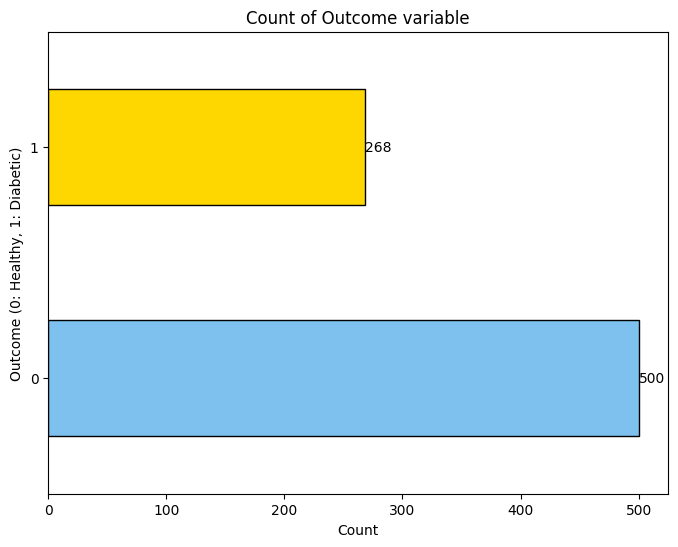

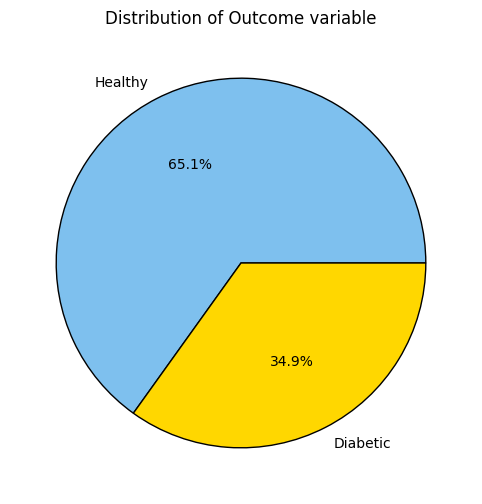

In [ ]:
# 2 datasets
D = df[(df['Outcome'] != 0)]
H = df[(df['Outcome'] == 0)]

#------------COUNT-----------------------
def target_count():
    plt.figure(figsize=(8, 6))
    # Count the values
    counts = df['Outcome'].value_counts()

    # Create horizontal bar chart
    counts.plot(kind='barh', color=['#7EC0EE', '#FFD700'], edgecolor='black')

    plt.title('Count of Outcome variable')
    plt.xlabel('Count')
    plt.ylabel('Outcome (0: Healthy, 1: Diabetic)')

    # Add text labels
    for index, value in enumerate(counts):
        plt.text(value, index, str(value), va='center')

    plt.show()

#------------PERCENTAGE-------------------
def target_percent():
    plt.figure(figsize=(8, 6))
    counts = df['Outcome'].value_counts()

    # Create pie chart
    plt.pie(counts, labels=['Healthy', 'Diabetic'], autopct='%1.1f%%',
            colors=['#7EC0EE', '#FFD700'], wedgeprops={'edgecolor': 'black'})

    plt.title('Distribution of Outcome variable')
    plt.show()

target_count()
target_percent()

3.4 Missing Values

Some features contain 0, which doesn't make sense here. This indicates missing value.
Below we replace 0 value by NaN :

In [ ]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.nan)

3.5 Visualize Missing Values

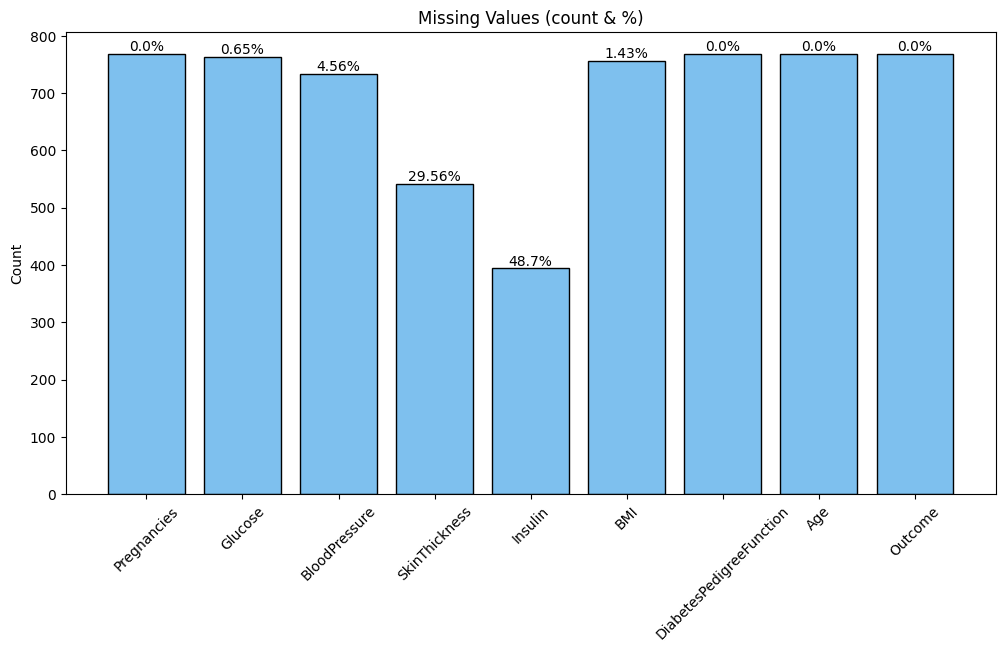

In [ ]:
def missing_plot(dataset, key):
    # Calculate nulls
    null_feat = pd.DataFrame(len(dataset[key]) - dataset.isnull().sum(), columns=['Count'])
    percentage_null = pd.DataFrame((len(dataset[key]) - (len(dataset[key]) - dataset.isnull().sum()))/len(dataset[key])*100, columns=['Count'])
    percentage_null = percentage_null.round(2)

    # Create plot
    plt.figure(figsize=(12, 6))

    # We plot the counts of PRESENT values (as per original code logic)
    bars = plt.bar(null_feat.index, null_feat['Count'], color='#7EC0EE', edgecolor='black')

    plt.title("Missing Values (count & %)")
    plt.ylabel("Count")
    plt.xticks(rotation=45)

    # Add percentage labels on top
    for i, bar in enumerate(bars):
        height = bar.get_height()
        # Get the corresponding percentage
        perc = percentage_null['Count'][i]
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{perc}%',
                ha='center', va='bottom')

    plt.show()

missing_plot(df, 'Outcome')

Missing values :
- Insulin = 48.7% - 374
- SkinThickness = 29.56% - 227
- BloodPressure = 4.56% - 35
- BMI = 1.43% - 11
- Glucose = 0.65% - 5

3.6 Dataset Overview

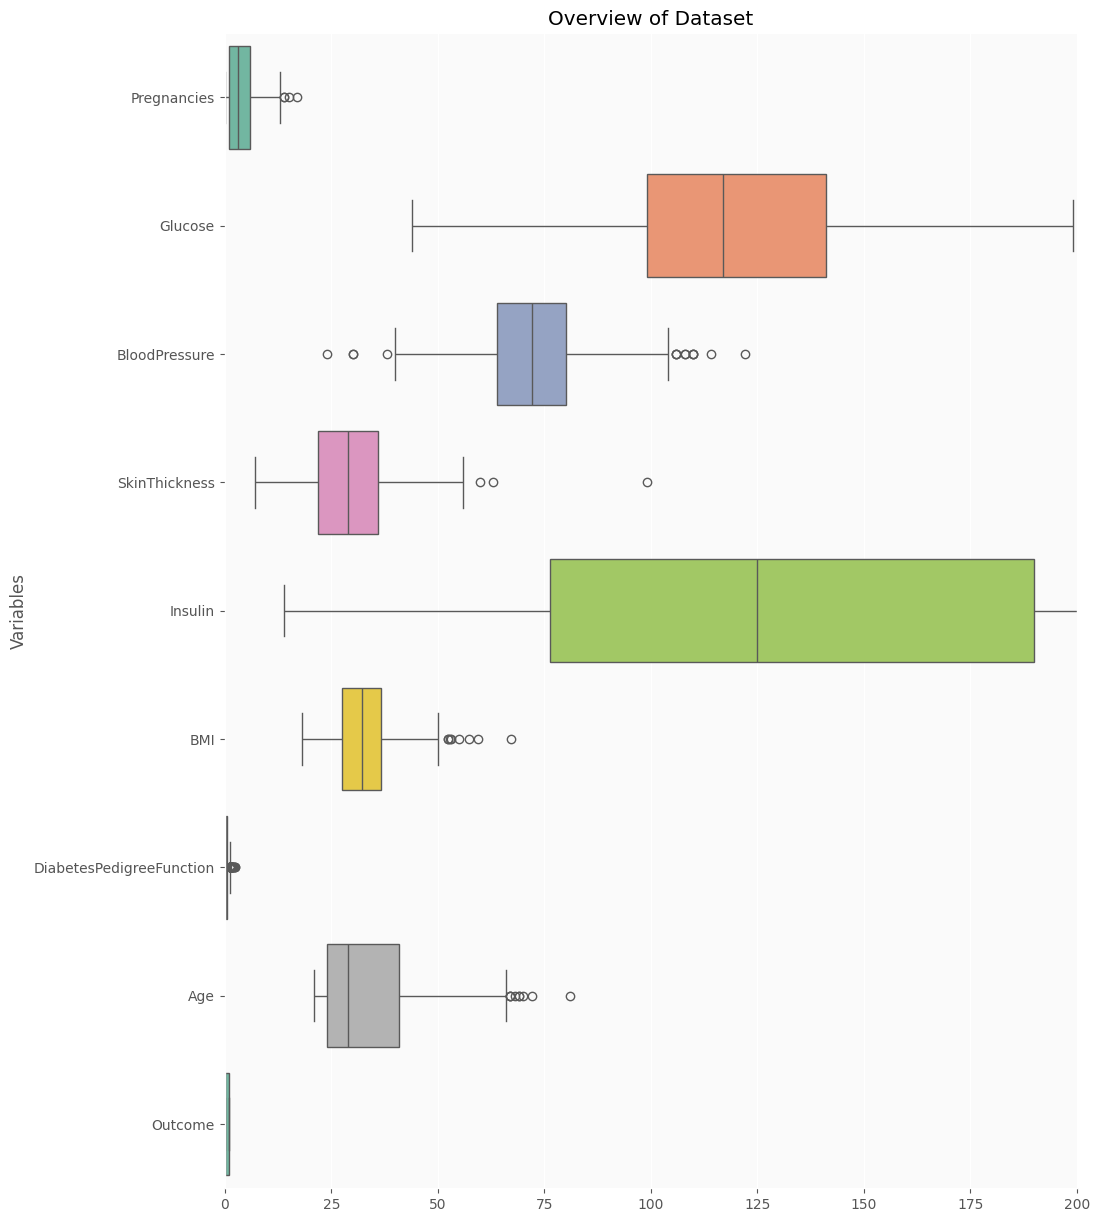

In [ ]:
plt.style.use('ggplot') # Using ggplot2 style visuals

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 200))
plt.ylabel('Variables')
plt.title("Overview of Dataset")
ax = sns.boxplot(data = df,
  orient = 'h',
  palette = 'Set2')

3.7 Correlation Matrix

A correlation matrix is a table showing correlation coefficients between sets of variables. Each random variable (Xi) in the table is correlated with each of the other values in the table (Xj). This allows you to see which pairs have the highest correlation.

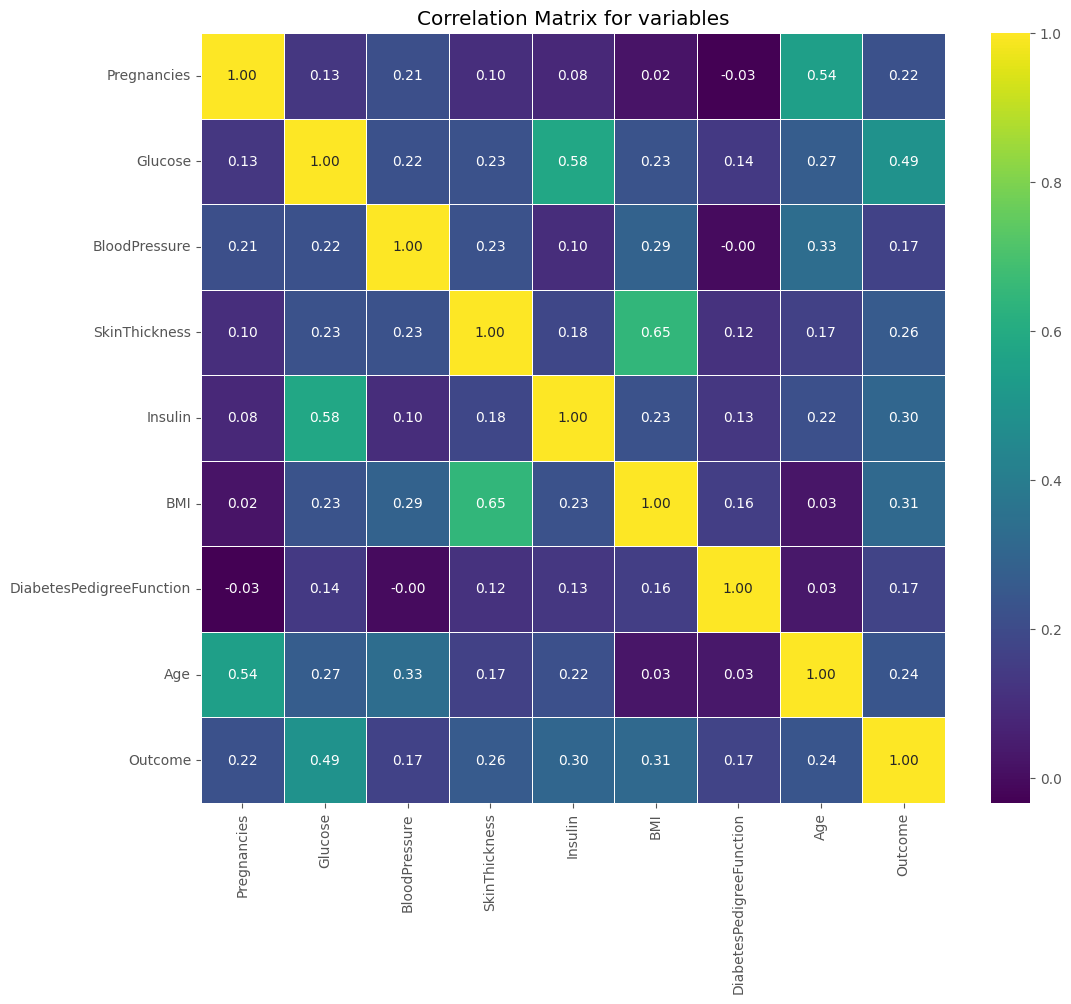

In [ ]:
def correlation_plot():
    plt.figure(figsize=(12, 10))
    correlation = df.corr()

    # Create Heatmap
    sns.heatmap(correlation, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)

    plt.title('Correlation Matrix for variables')
    plt.show()

correlation_plot()

## IV. Feature Engineering

4.1 Replace Missing Values

Replace missing values using median by target (Outcome)

In [ ]:
def median_target(var):
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

4.2 Defining Distribution Plot Function

In [ ]:
def plot_distribution(data_select, size_bin):
    plt.figure(figsize=(10, 6))

    # Create the distribution plot with histograms and density curves
    sns.histplot(data=df, x=data_select, hue='Outcome', kde=True,
                palette={0: '#7EC0EE', 1: '#FFD700'},
                element="step", bins=int(df[data_select].max()/size_bin) if size_bin > 0 else 'auto')

    plt.title(f'{data_select} Distribution')
    plt.legend(title='Outcome', labels=['Diabetic', 'Healthy'])
    plt.show()

- Insulin

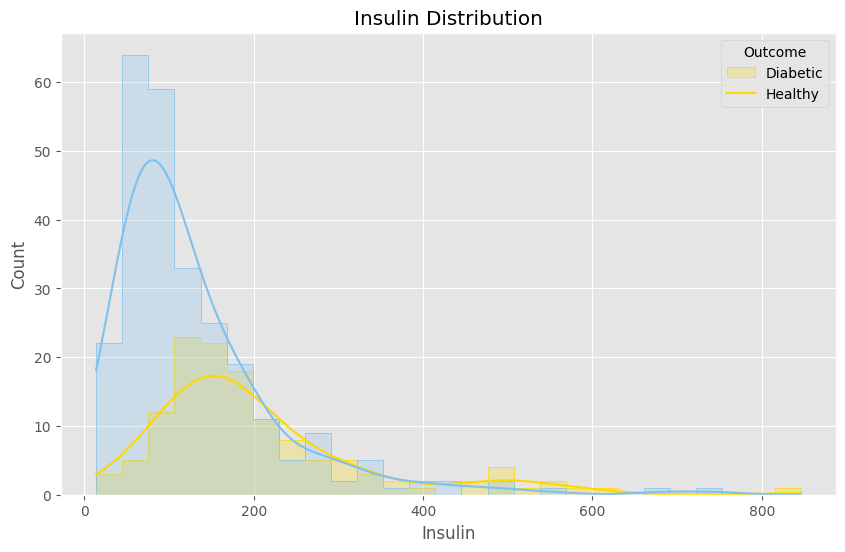

In [ ]:
plot_distribution('Insulin', 0)

In [ ]:
median_target('Insulin')

,Outcome,Insulin
0,0,102.5
1,1,169.5


Replace the missing value of insulin of each healthy person with 102.5 and each diabetic person with 169.5

In [ ]:
df.loc[(df['Outcome'] == 0 ) & (df['Insulin'].isnull()), 'Insulin'] = 102.5
df.loc[(df['Outcome'] == 1 ) & (df['Insulin'].isnull()), 'Insulin'] = 169.5

- Glucose

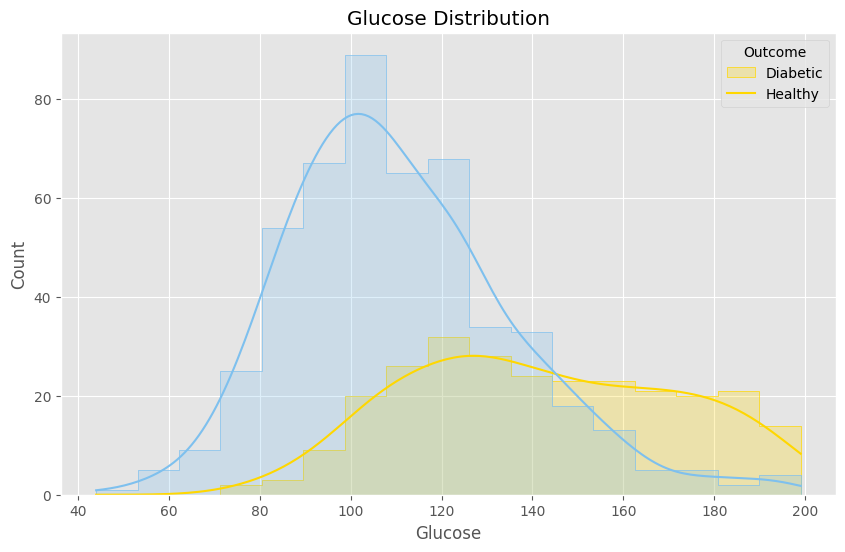

In [ ]:
plot_distribution('Glucose', 0)

In [ ]:
median_target('Glucose')

,Outcome,Glucose
0,0,107.0
1,1,140.0


Replace the missing value of glucose of each healthy person with 107.0 and each diabetic person with 140.0

In [ ]:
df.loc[(df['Outcome'] == 0 ) & (df['Glucose'].isnull()), 'Glucose'] = 107
df.loc[(df['Outcome'] == 1 ) & (df['Glucose'].isnull()), 'Glucose'] = 140

- Skin Thickness

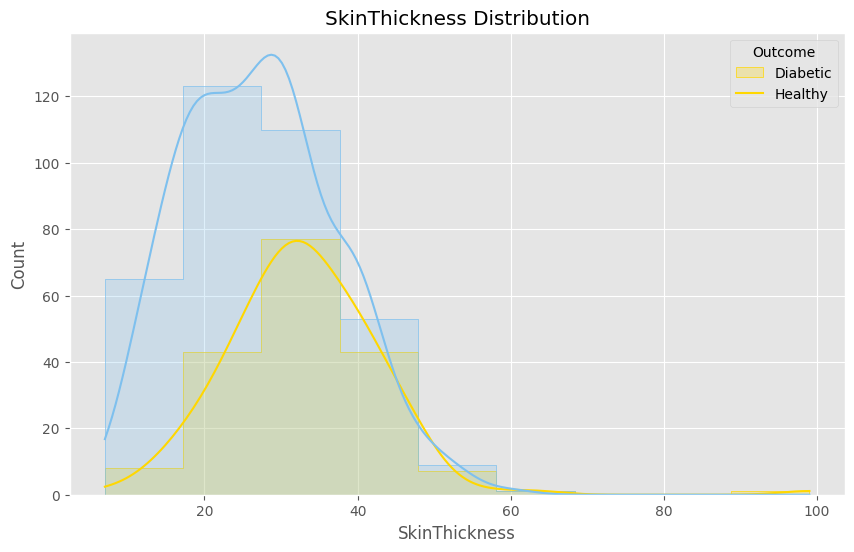

In [ ]:
plot_distribution('SkinThickness', 10)

In [ ]:
median_target('SkinThickness')

,Outcome,SkinThickness
0,0,27.0
1,1,32.0


Replace the missing value of skin thickness of each healthy person with 27.0 and each diabetic person with 32.0

In [ ]:
df.loc[(df['Outcome'] == 0 ) & (df['SkinThickness'].isnull()), 'SkinThickness'] = 27
df.loc[(df['Outcome'] == 1 ) & (df['SkinThickness'].isnull()), 'SkinThickness'] = 32

- Blood Pressure

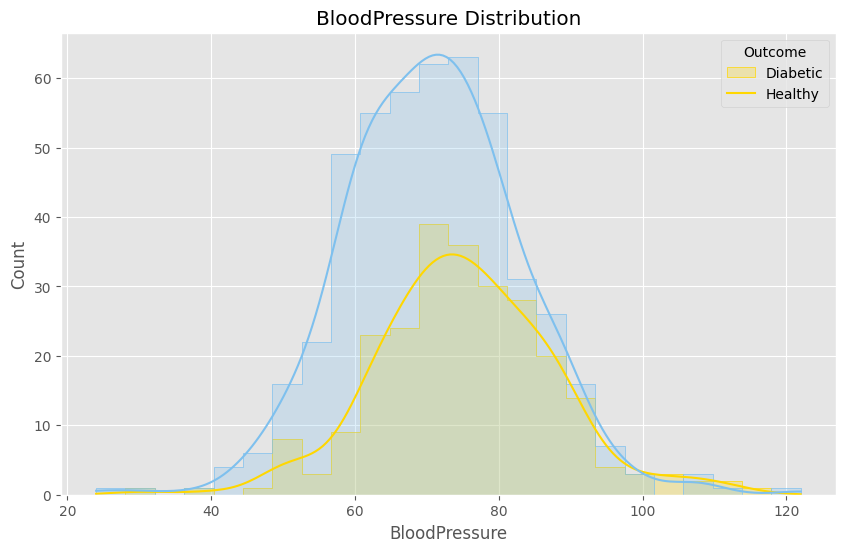

In [ ]:
plot_distribution('BloodPressure', 5)

In [ ]:
median_target('BloodPressure')

,Outcome,BloodPressure
0,0,70.0
1,1,74.5


Replace the missing value of blood pressure of each healthy person with 70.0 and each diabetic person with 74.5

In [ ]:
df.loc[(df['Outcome'] == 0 ) & (df['BloodPressure'].isnull()), 'BloodPressure'] = 70
df.loc[(df['Outcome'] == 1 ) & (df['BloodPressure'].isnull()), 'BloodPressure'] = 74.5

- BMI

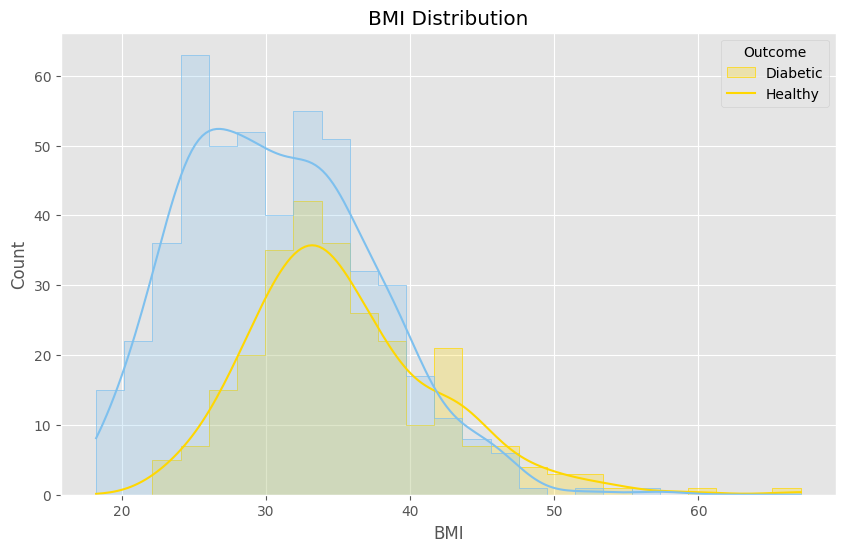

In [ ]:
plot_distribution('BMI', 0)

In [ ]:
median_target('BMI')

,Outcome,BMI
0,0,30.1
1,1,34.3


Replace the missing value of BMI of each healthy person with 30.1 and each diabetic person with 34.3

In [ ]:
df.loc[(df['Outcome'] == 0 ) & (df['BMI'].isnull()), 'BMI'] = 30.1
df.loc[(df['Outcome'] == 1 ) & (df['BMI'].isnull()), 'BMI'] = 34.3

- Other Attributes

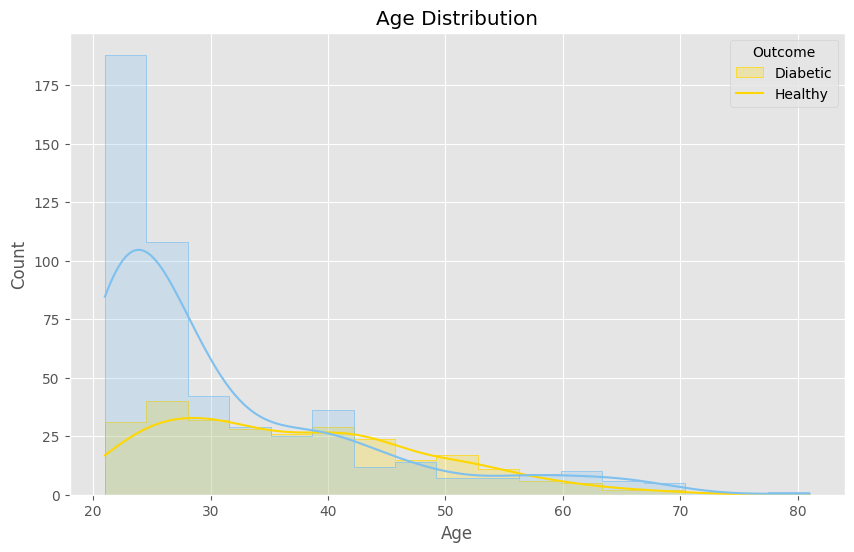

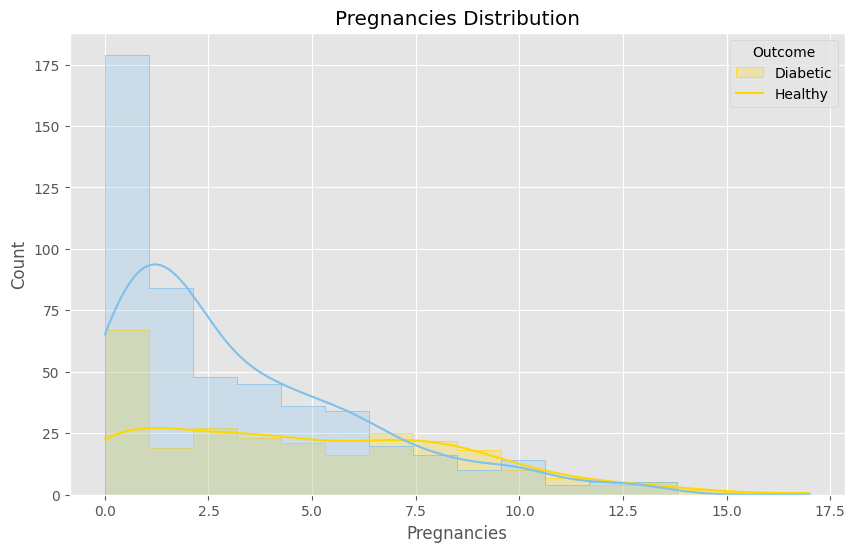

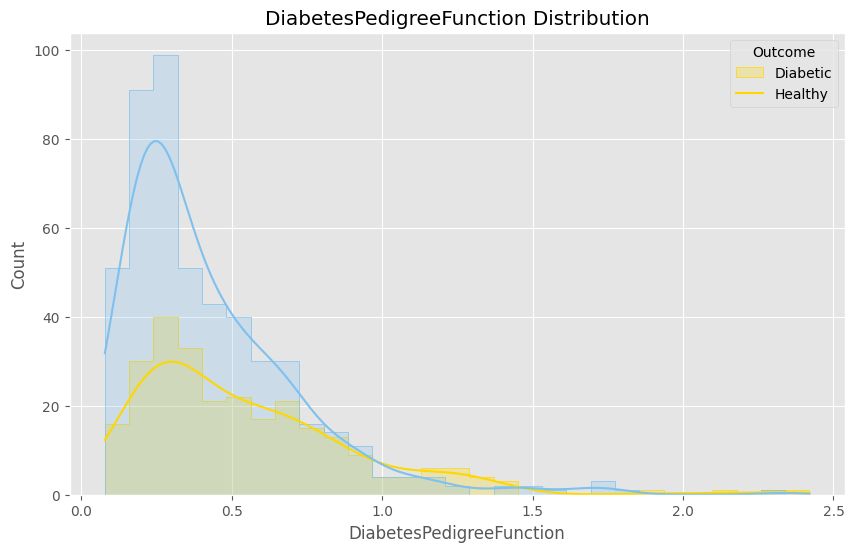

In [ ]:
plot_distribution('Age', 0)
plot_distribution('Pregnancies', 0)
plot_distribution('DiabetesPedigreeFunction', 0)

Check for missing values after replacing them

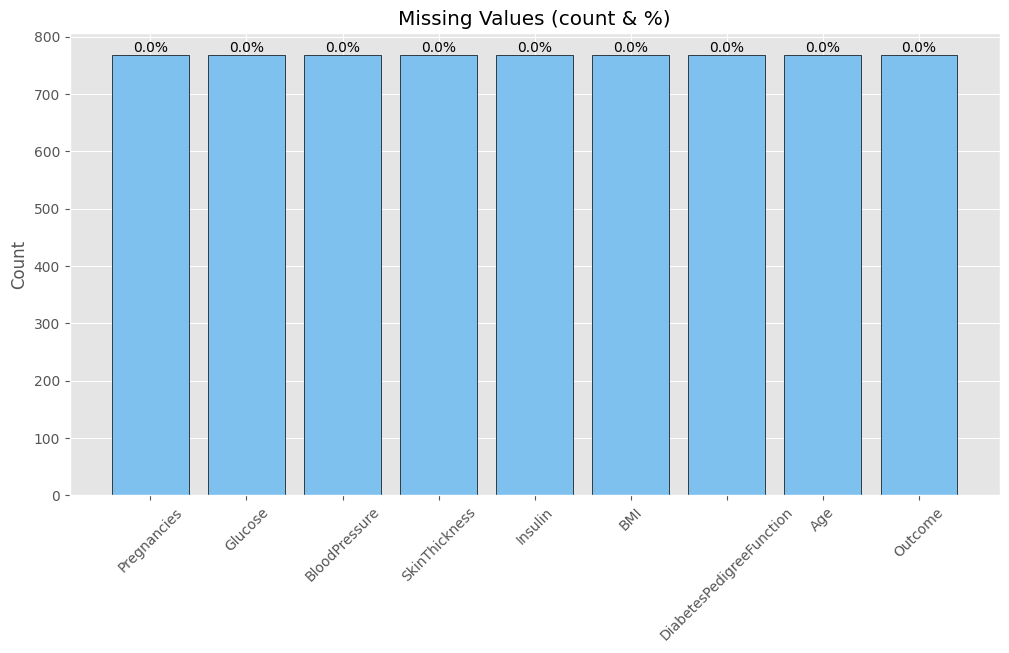

In [ ]:
missing_plot(df, 'Outcome')

All features are now complete.

**4.3 New Features**

Define Scatter Plot Function

In [ ]:
def plot_feat1_feat2(feat1, feat2):
    plt.figure(figsize=(10, 6))

    # Create scatter plot
    sns.scatterplot(data=df, x=feat1, y=feat2, hue='Outcome',
                    palette={0: '#7EC0EE', 1: '#FFD700'}, edgecolor='black', alpha=0.7)

    plt.title(f'{feat1} vs {feat2}')
    plt.legend(title='Outcome', labels=['Diabetic', 'Healthy'])
    plt.show()

- Glucose & Age

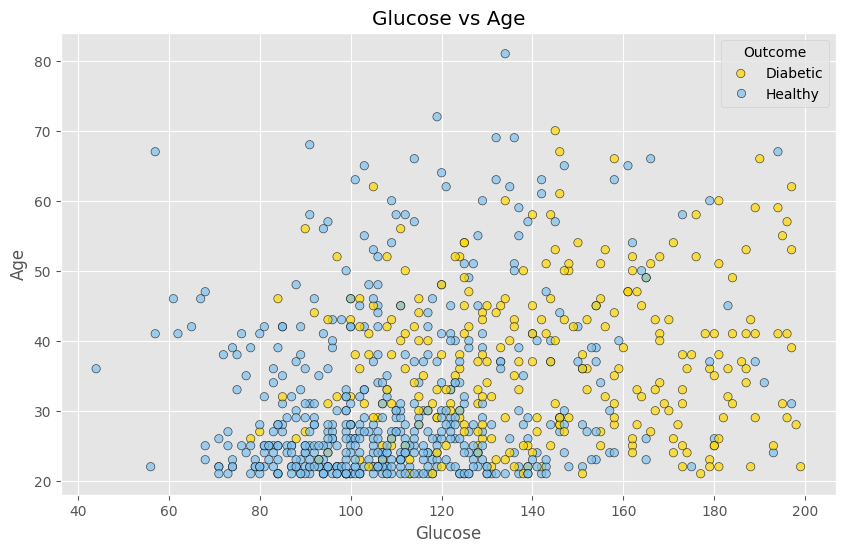

In [ ]:
plot_feat1_feat2('Glucose','Age')

It can be observed that healthy persons are concentrated with an age <= 30 and glucose <= 120.
![image.png](attachment:image.png)

Create new feature (N1)

In [ ]:
df.loc[:,'N1']=0
df.loc[(df['Age']<=30) & (df['Glucose']<=120),'N1']=1

- BMI

According to World Health Organization (WHO), a BMI over 30 is considered obese.
https://www.who.int/health-topics/obesity#tab=tab_1

Create new feature (N2)

In [ ]:
df.loc[:,'N2']=0
df.loc[(df['BMI']<=30),'N2']=1

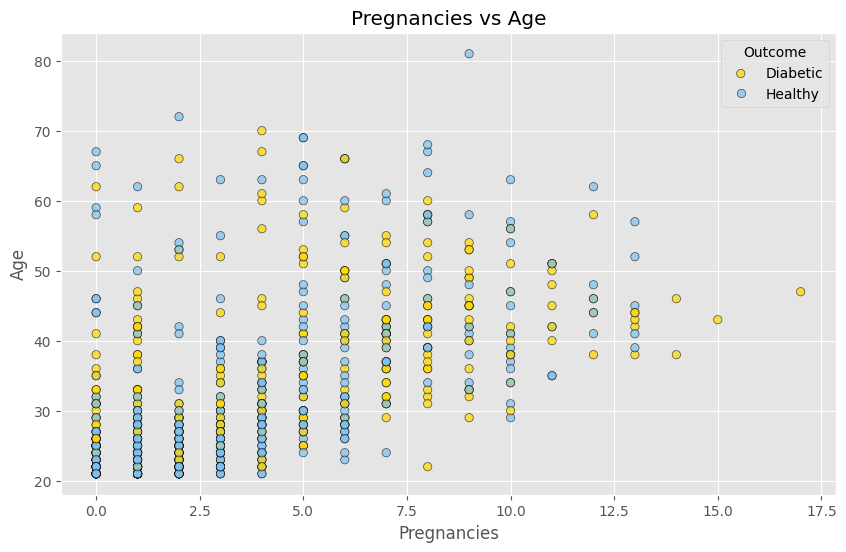

In [ ]:
plot_feat1_feat2('Pregnancies','Age')

- Pregnancies & Age

It can be observed that healthy persons are concentrated with an age <= 30 and pregnancies <= 6.
![image.png](attachment:image.png)

Create new feature (N3)

In [ ]:
df.loc[:,'N3']=0
df.loc[(df['Age']<=30) & (df['Pregnancies']<=6),'N3']=1

- Glucose & BloodPressure

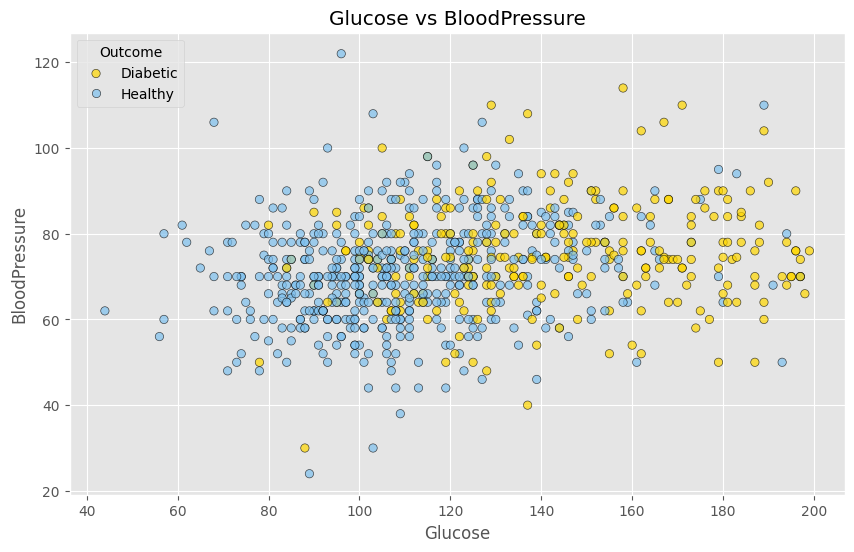

In [ ]:
plot_feat1_feat2('Glucose','BloodPressure')

Healthy persons are concentrated with an blood pressure <= 80 and glucose <= 105.
![image.png](attachment:image.png)

Create new feature (N4)

In [ ]:
df.loc[:,'N4']=0
df.loc[(df['Glucose']<=105) & (df['BloodPressure']<=80),'N4']=1

- SkinThickness

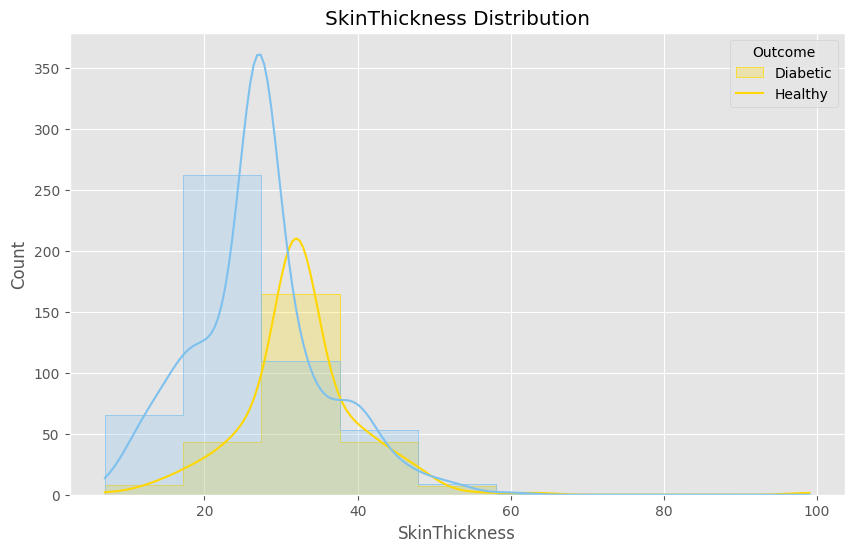

In [ ]:
plot_distribution('SkinThickness', 10)

It can be observed that healthy persons are concentrated with a SkinThickness <= 20.

Create a new feature (N5)

In [ ]:
df.loc[:,'N5']=0
df.loc[(df['SkinThickness']<=20) ,'N5']=1

- SkinThickness & BMI

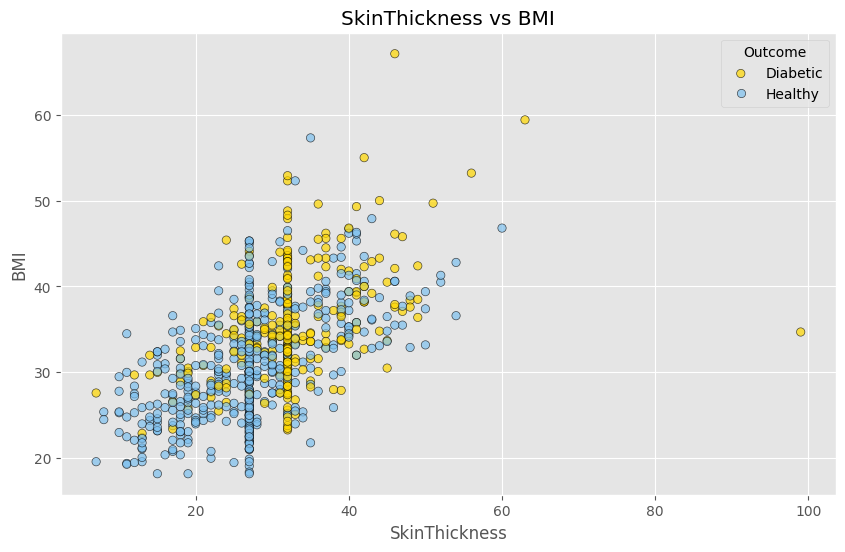

In [ ]:
plot_feat1_feat2('SkinThickness','BMI')

It can be observed that healthy persons are concentrated with a BMI < 30 and skin thickness <= 20.
![image.png](attachment:image.png)

Create a new feature (N6)

In [ ]:
df.loc[:,'N6']=0
df.loc[(df['BMI']<30) & (df['SkinThickness']<=20),'N6']=1

- Glucose & BMI

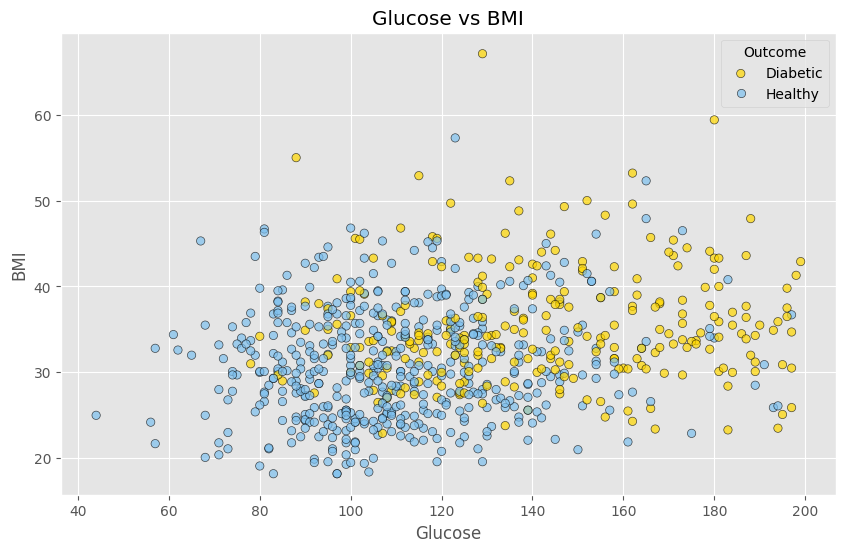

In [ ]:
plot_feat1_feat2('Glucose','BMI')

It can be observed that healthy persons are concentrated with Glucose <= 105 & BMI <= 30.
![image.png](attachment:image.png)

Create new a feature (N7)

In [ ]:
df.loc[:,'N7']=0
df.loc[(df['Glucose']<=105) & (df['BMI']<=30),'N7']=1

- Insulin

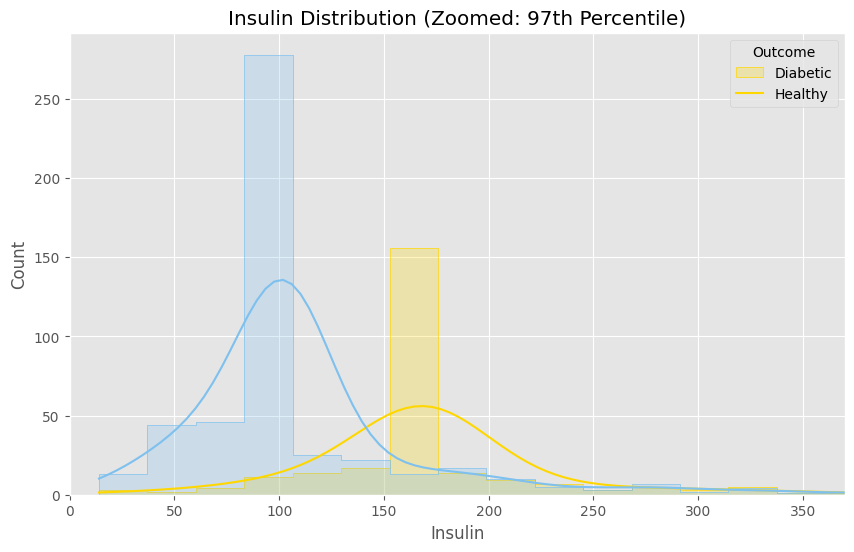

In [ ]:
def zoomed_plot_distribution(data_select, size_bin, percentile, zoom=False):
    plt.figure(figsize=(10, 6))

    limit = df[data_select].quantile(percentile/100) if zoom else df[data_select].max()

    # Create the plot
    sns.histplot(data=df, x=data_select, hue='Outcome', kde=True,
                palette={0: '#7EC0EE', 1: '#FFD700'},
                element="step",
                # We limit bins calculation to the zoomed range so bars look correct
                bins=int(limit/size_bin) if size_bin > 0 else 'auto')

    plt.xlim(0, limit)

    title_suffix = f" (Zoomed: {percentile}th Percentile)" if zoom else ""
    plt.title(f'{data_select} Distribution{title_suffix}')
    plt.legend(title='Outcome', labels=['Diabetic', 'Healthy'])
    plt.show()

zoomed_plot_distribution('Insulin', 10, percentile=97, zoom=True)

It can be observed that healthy persons are concentrated with Insulin < 150

Create new feature (N8)

In [ ]:
df.loc[:,'N8']=0
df.loc[(df['Insulin']<150),'N8']=1

- BloodPressure

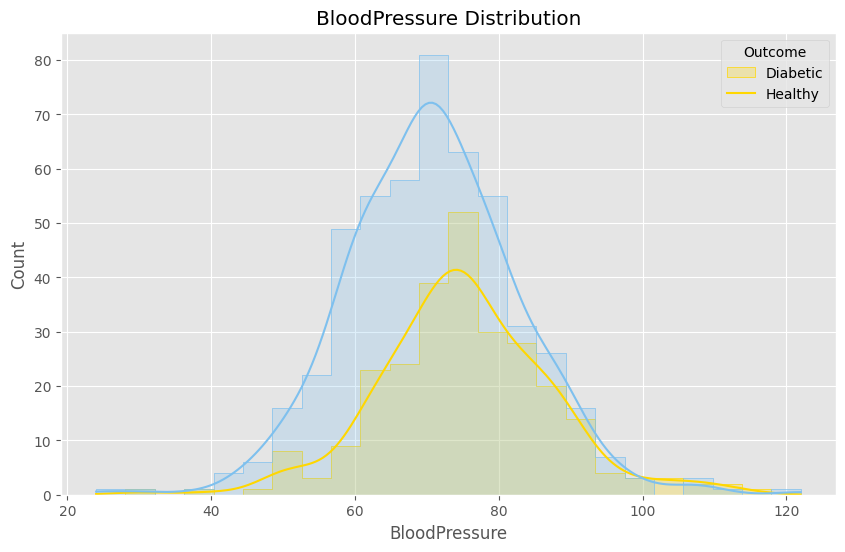

In [ ]:
plot_distribution('BloodPressure', 5)

It can be observed that healthy persons are concentrated with BloodPressure < 80.

Create a new feature (N9)

In [ ]:
df.loc[:,'N9']=0
df.loc[(df['BloodPressure']<80),'N9']=1

- Pregnancies

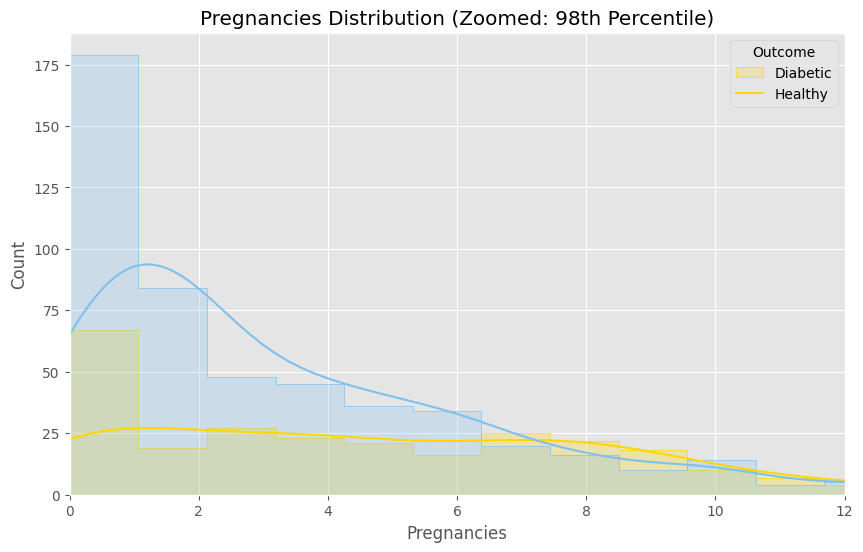

In [ ]:
zoomed_plot_distribution('Pregnancies', 0, 98, zoom=True)

It can be observed that healthy persons are concentrated with pregnancies < 4.

Create new feature (N10)

In [ ]:
df.loc[:,'N10']=0
df.loc[(df['Pregnancies']<4) & (df['Pregnancies']!=0) ,'N10']=1

- Other Features

In [ ]:
df['N0'] = df['BMI'] * df['SkinThickness']

df['N11'] =  df['Pregnancies'] / df['Age']

df['N12'] = df['Glucose'] / df['DiabetesPedigreeFunction']

df['N13'] = df['Age'] * df['DiabetesPedigreeFunction']

df['N14'] = df['Age'] / df['Insulin']

- Feature extracted from N0

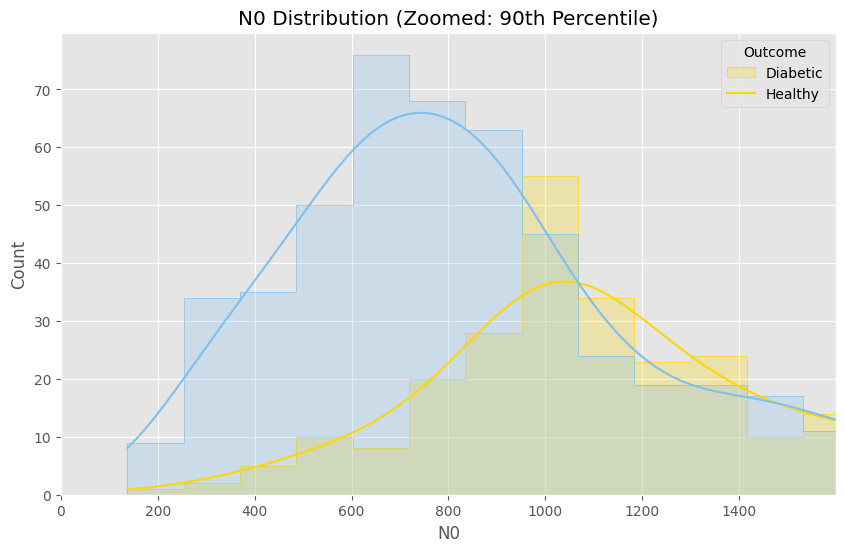

In [ ]:
zoomed_plot_distribution('N0', 0, 90, zoom=True)

Create new feature (N15)

In [ ]:
df.loc[:,'N15']=0
df.loc[(df['N0']<1034) ,'N15']=1

In [ ]:
D = df[(df['Outcome'] != 0)]
H = df[(df['Outcome'] == 0)]

## Correlation Matrix

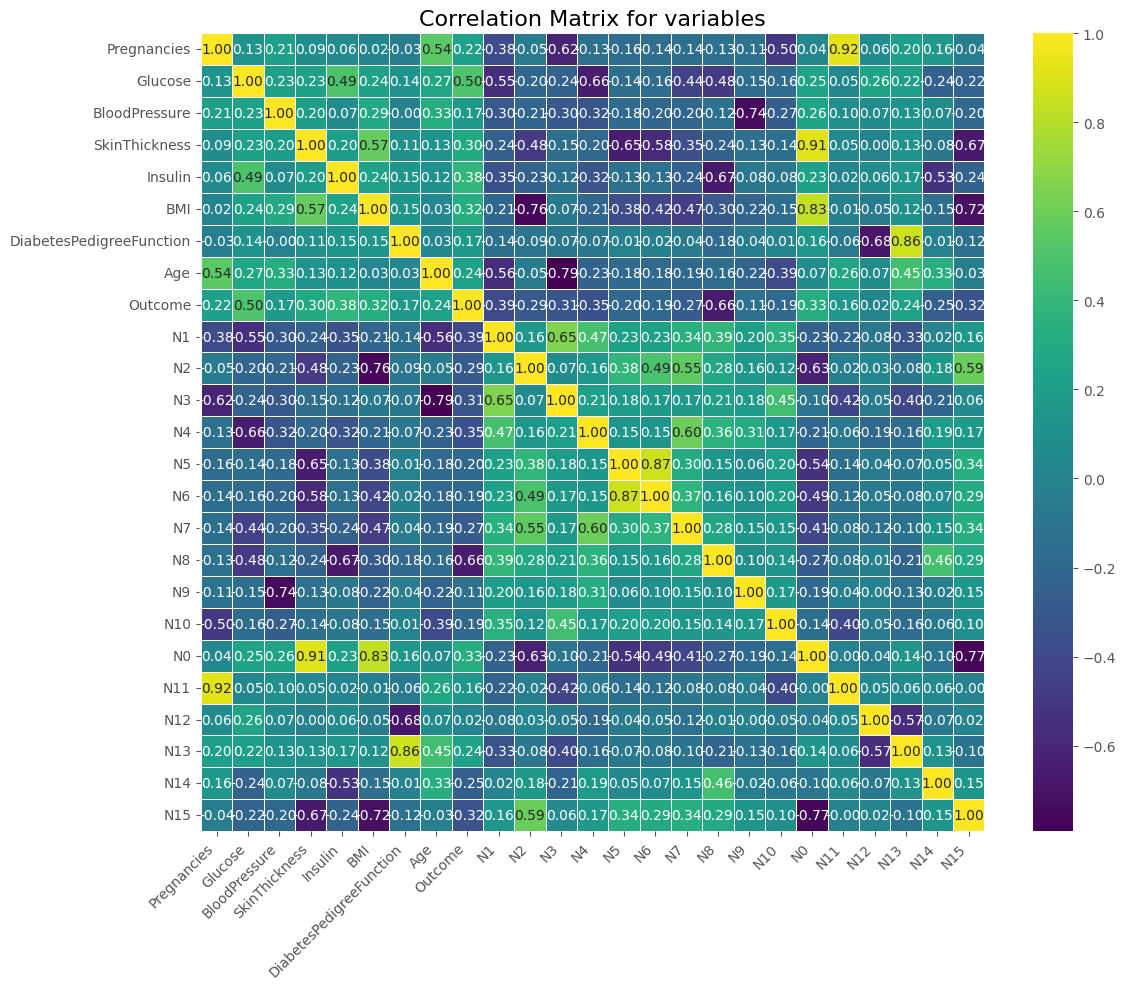

In [ ]:
def correlation_plot():
    # 1. Calculate Correlation
    correlation = df.corr()

    # 2. Setup Plot Size
    plt.figure(figsize=(12, 10))

    # 3. Create Heatmap
    # annot=True: Shows the numbers inside the squares
    # fmt=".2f": Rounds numbers to 2 decimal places
    # cmap='viridis': color scheme
    sns.heatmap(correlation, annot=True, fmt=".2f", cmap='viridis',
                linewidths=0.5, linecolor='white')

    # 4. Styling
    plt.title('Correlation Matrix for variables', fontsize=16)
    plt.xticks(rotation=45, ha='right') # Rotate x labels for readability
    plt.yticks(rotation=0)              # Keep y labels horizontal

    plt.tight_layout() # Prevents labels from being cut off
    plt.show()

correlation_plot()

## X and Y

In [ ]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,N1,...,N7,N8,N9,N10,N0,N11,N12,N13,N14,N15
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,0,...,0,0,1,0,1176.0,0.120000,236.044657,31.350,0.294985,0
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,0,...,1,1,1,1,771.4,0.032258,242.165242,10.881,0.302439,1
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,0,...,0,0,1,0,745.6,0.250000,272.321429,21.504,0.188791,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,1,...,1,1,1,1,646.3,0.047619,532.934132,3.507,0.223404,1
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,0,...,0,0,1,0,1508.5,0.000000,59.877622,75.504,0.196429,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0,0,...,0,0,1,0,1579.2,0.158730,590.643275,10.773,0.350000,0
764,2,122.0,70.0,27.0,102.5,36.8,0.340,27,0,0,...,0,1,1,1,993.6,0.074074,358.823529,9.180,0.263415,1
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0,0,...,0,1,1,0,602.6,0.166667,493.877551,7.350,0.267857,1
766,1,126.0,60.0,32.0,169.5,30.1,0.349,47,1,0,...,0,0,1,1,963.2,0.021277,361.031519,16.403,0.277286,1


Define X and Y

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Split the data
# test_size=0.2 means 20% of data is saved for testing, 80% for training
# random_state=42 ensures you get the same split every time you run it
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 614 samples
Testing set size: 154 samples


## Model Performance and Scores Table

In [ ]:
def model_performance(model, subtitle):
    # KFold with Shuffle=True to fix the previous ValueError
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    plt.figure(figsize=(10, 6))

    i = 0
    # Loop through folds
    for train, test in cv.split(X, y):
        model.fit(X.iloc[train], y.iloc[train])
        probas_ = model.predict_proba(X.iloc[test])

        # Compute ROC curve and area
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])

        # Use np.interp (fixed NameError)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        # Plot individual fold
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {roc_auc:.2f})')
        i += 1

    # Plot Mean ROC
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    plt.plot(mean_fpr, mean_tpr, color='b',
            label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})',
            lw=2, alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {subtitle}')
    plt.legend(loc="lower right")
    plt.show()

def scores_table(model, subtitle):
    # Train/Test Split (Simple evaluation for the bar chart)
    # Ideally, we use the metrics from the best model found

    preds = model.predict(X)

    acc = accuracy_score(y, preds)
    prec = precision_score(y, preds)
    rec = recall_score(y, preds)
    f1 = f1_score(y, preds)

    scores = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Score': [acc, prec, rec, f1]
    })

    # Fixed np.round_ error by using np.round
    scores['Score'] = np.round(scores['Score'], 4)

    # Plotting using Matplotlib
    plt.figure(figsize=(8, 5))
    bars = plt.barh(scores['Metric'], scores['Score'], color=['gold', 'lightgreen', 'lightcoral', 'lightskyblue'], edgecolor='black')

    plt.xlim(0, 1.1)
    plt.title(f'Model Metrics: {subtitle}')
    plt.xlabel('Score')

    # Add text labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{width}',
                va='center')

    plt.show()

    # Display table
    print(scores)

### V. Machine Learning (RandomForest)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

random_state = None

# --- RANDOM FOREST CONFIGURATION ---

# Define parameters specific to Random Forest
param_test = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 20, 30, 40],
    'min_samples_split': sp_randint(2, 20),
    'min_samples_leaf': sp_randint(1, 20),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

# Number of combinations
n_iter = 300

# Initialize RandomForest and launch the search
# n_jobs=-1 allows it to use all processors for faster computation
rf_clf = RandomForestClassifier(random_state=random_state, n_jobs=-1)

grid_search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_test,
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=random_state,
    verbose=True
)

# Fit the model
grid_search.fit(X_train, y_train)

# Retrieve best parameters and define the final model
opt_parameters = grid_search.best_params_
# Re-instantiate with best params
rf_clf = RandomForestClassifier(**opt_parameters, random_state=random_state, n_jobs=-1)

rf_clf.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomForestClassifier(bootstrap=False, criterion='entropy',
                       min_samples_leaf=15, min_samples_split=15, n_jobs=-1)

Saving the model to .joblib file

In [ ]:
import joblib

# Save the model to a file
# compress=3 helps reduce file size (0-9, where 9 is max compression)
joblib.dump(rf_clf, 'random_forest_diabetes_predictor_model.pkl', compress=3)

print("Model saved successfully!")

Model saved successfully!


## VI. Final Evaluation

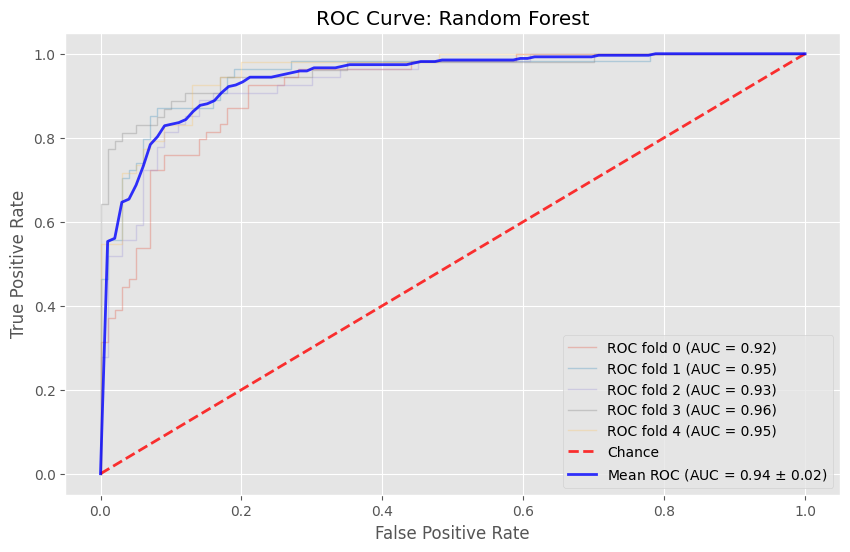

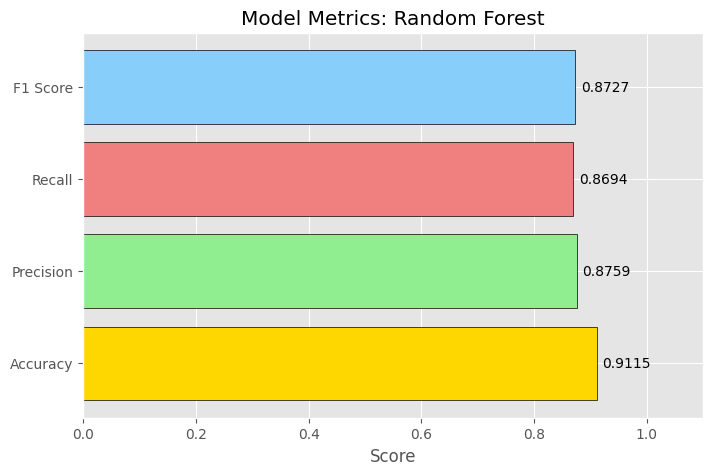

      Metric   Score
0   Accuracy  0.9115
1  Precision  0.8759
2     Recall  0.8694
3   F1 Score  0.8727


In [ ]:
model_performance(rf_clf, 'Random Forest')
scores_table(rf_clf, 'Random Forest')

# VII. Testing

--- PERFORMANCE ON UNSEEN DATA (20%) ---
Final Accuracy: 90.91%

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       100
           1       0.87      0.87      0.87        54

    accuracy                           0.91       154
   macro avg       0.90      0.90      0.90       154
weighted avg       0.91      0.91      0.91       154



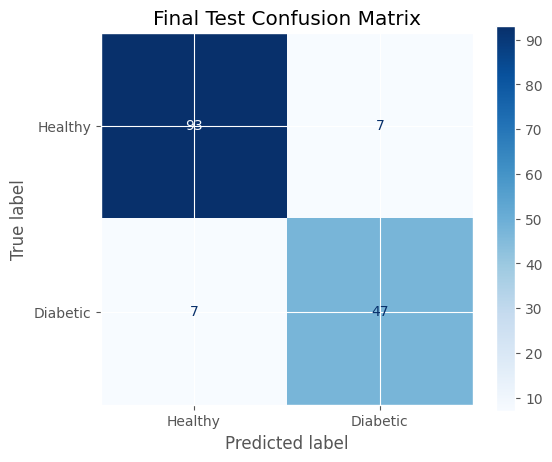

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ==========================================
# FINAL EVALUATION: TESTING ON THE 20% SPLIT
# ==========================================

y_test_pred = rf_clf.predict(X_test)

print("--- PERFORMANCE ON UNSEEN DATA (20%) ---")
print(f"Final Accuracy: {accuracy_score(y_test, y_test_pred):.2%}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_test_pred))

# Plot the Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Diabetic'])

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title("Final Test Confusion Matrix")
plt.show()